In [1]:
import pandas as pd
import seaborn as sns
from pyiron_atomistics import ase_to_pyiron
import matplotlib.pyplot as plt
from pychromatic import Multiplot

/home/menon/miniconda3/envs/potentials2023/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [12]:
from scipy.spatial import ConvexHull

In [2]:
df = pd.read_pickle('AlLi_dataset.pkl.gz', compression='gzip')

In [3]:
def get_conc(structure, of='Li'):
    return sum(structure.symbols == of)/len(structure)

In [4]:
df['atoms'] = df.ase_atoms.map(ase_to_pyiron)

In [5]:
df['c_Li'] = df.atoms.map(get_conc)

In [6]:
df['N'] = df.atoms.map(len)

In [7]:
df['e'] = df.energy_corrected / df.N

In [8]:
e0 = df.query('c_Li==0').e.min()
e1 = df.query('c_Li==1').e.min()

In [9]:
df['energy_above_hull'] = df.e - (e0 * (1 - df.c_Li) + e1 * df.c_Li)

In [13]:
hull = ConvexHull(df[['c_Li','energy_above_hull']])

In [14]:
hdf = df.iloc[hull.vertices].query('energy_above_hull <= 0')

In [18]:
colors = {"g": "#1b9e77", "r": "#d95f02", "b": "#7570b3"}

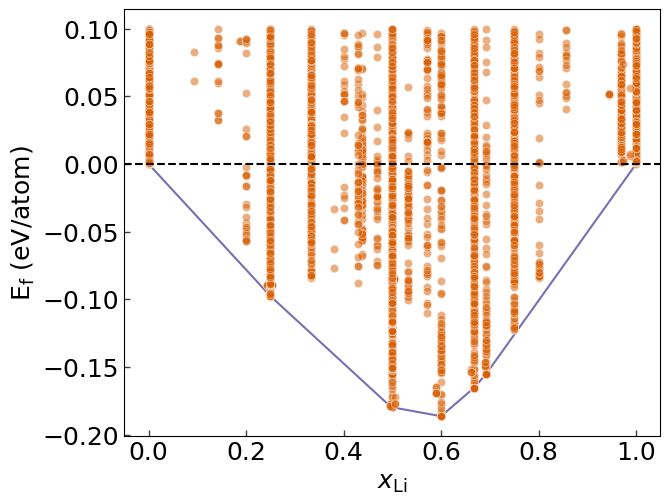

In [19]:
mlt = Multiplot(width=500, ratio=0.8)
sns.scatterplot(
    data=df.query('energy_above_hull <= 1e-1'),
    x='c_Li', y='energy_above_hull',
    c = colors["r"],
    alpha=0.5,
    #edgecolor='black'
    
)
sns.lineplot(
    data=hdf,
    x='c_Li', y='energy_above_hull',
    color=colors["b"], zorder=-1
)
plt.axhline(0.00, ls='dashed', color='black')
mlt[0,0].set_xlabel("$x_\mathrm{Li}$")
mlt[0,0].set_ylabel(r"E$_\mathrm{f}$ (eV/atom)")
plt.savefig("training_convex_hull.png", dpi=300, bbox_inches='tight')